# 综合实战作业 1



在本次作业中，我们将使用 NumPy 和 PyTorch 计算第一讲中生成的字符图像间的相似度并进行排序，输出不同相似度的图像对。你只需要在 `# >>> TODO` 和 `# <<< TODO` 间填写代码。

## 数据读取

首先，让我们定义加载数据集的函数。步骤如下：

- 先使用 `pathlib.Path.glob` 找出所有扩展名为 `.jpg` 的文件。如果你不习惯使用 `pathlib` 库，可以用 `os` 和 `glob` 库替代。
- 再使用 `cv2.imread` 读取图像并用 `cv2.cvtColor` 转换为灰度格式，并用 `pathlib.Path.stem` 提取文件名。
- 通过列表生成式生成所有的数据条目 `data`。

`data` 中每条数据的格式为 `(img_name: str, img: numpy.ndarray)`。

In [2]:
import cv2
from pathlib import Path
import numpy as np

def load_dataset(data_root):
    search_path = Path(data_root)  #马上要搜索的目录是data_root
    jpg_files = list(search_path.glob('**/*.jpg'))  #搜索所有后缀为jpg的文件
    data = [[file.stem, cv2.cvtColor(cv2.imread(str(file)),cv2.COLOR_BGR2GRAY)] for file in jpg_files]  #每条数据是一个列表
    #首元素是文件名，第二个元素是图片的灰度图（灰度图是一个48*48的矩阵，二维数组）
    return data
data = load_dataset(r'.\data')

让我们读取数据集，并使用 `matplotlib` 打印图像看看它长什么样子。

(48, 48)


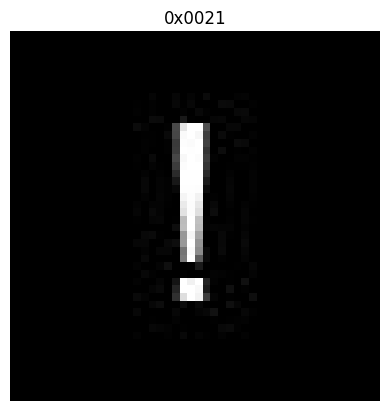

In [15]:
import matplotlib.pyplot as plt

data = load_dataset(r".\data")

def imshow(img, title=None):
    plt.figure()
    plt.imshow(img, cmap='gray')
    if title is not None:
         plt.title(title)
    plt.axis('off')

img_name, img = data[0] #取出第一张图片，前面是文件名，后面是图片的灰度图
imshow(img, img_name)
print(img.shape)

我们检测重复和相似图像的原理是计算图像向量间的余弦相似度。对于图像 $\mathbf X_1, \mathbf X_2 \in M_{H,W,C} (\mathbb R)$，我们首先将其展平为列向量 $\boldsymbol y_1, \boldsymbol y_2 \in \mathbb R^{HWC}$，然后计算两个向量的余弦相似度：
$$
S_{C}(\boldsymbol y_1, \boldsymbol y_2):=\frac{\boldsymbol y_1 \cdot \boldsymbol y_2}{\|\boldsymbol y_1 \|\|\boldsymbol y_2 \|}
$$
相似度越接近 1，说明两幅图像越相似。在计算相似度时，建议先将像素取值转换为浮点数并归一化，防止溢出和数据类型带来的问题。

下面我们将按照这个思路，分别采用 NumPy 和 PyTorch 实现计算图像相似度的算法（PyTorch 部分内容可在第三讲培训之后完成），并对比不同实现的速度。特别地，对于 NumPy， 我们先尝试简单的多重 for 循环的实现，再尝试采用矩阵计算的实现。

## 使用 NumPy 和两重循环

下面请你用两重循环，计算图片间的两两相似度，并将相似度取值和对应的图像对序号保存到列表中。注意不要包括“图像自己和自己组成的图像对”以及“可交换顺序的图像组成的图像对”。

In [16]:
import numpy as np

similarity_list = []
pair_list = []
# >>> TODO
for i in range(len(data)):
    for j in range(i+1,len(data)):
        pair_list.append((i,j))  #记录图片的索引（插入一个二元组）
        norm_img_1 = np.ravel(data[i][1].astype(np.float32)/255)
        norm_img_2 = np.ravel(data[j][1].astype(np.float32)/255) #归一化
        cos_theta = np.dot(norm_img_1,norm_img_2)/(np.linalg.norm(norm_img_1)*np.linalg.norm(norm_img_2))  #计算相似度（夹角余弦值）
        similarity_list.append(cos_theta) #记录相似度
similarity_list = np.array(similarity_list) #转换为numpy数组
pair_list = np.array(pair_list)  #转换为numpy数组

挺慢是吧！下一节直接用矩阵计算时，你就能非常直观地感受运算速度的差别。

下面请你按照从大到小的顺序对相似度进行排序，保存排序后的索引列表。

In [17]:
sorted_similarity_list = np.argsort(similarity_list,axis=None)[::-1]

## 使用 NumPy 和矩阵运算

其实，我们可以使用矩阵运算一次性计算所有图像的两两相似度，这可以大大加快计算速度。计算公式如下：
$$
\mathbf Y = \begin{pmatrix}
\boldsymbol y_1^\intercal \\
\boldsymbol y_2^\intercal \\
\vdots \\
\boldsymbol y_n^\intercal
\end{pmatrix}
\\
\mathbf W = \mathbf Y \mathbf Y^\intercal \\
\mathbf N = (\|\boldsymbol y_1 \|, \|\boldsymbol y_2 \|, \dots, \|\boldsymbol y_n \|)^\intercal(\|\boldsymbol y_1 \|, \|\boldsymbol y_2 \|, \dots, \|\boldsymbol y_n \|) \\
\mathbf S = \mathbf W \oslash \mathbf N
$$

其中 $\oslash$ 表示逐元素除法。则图像 $\mathbf X_i, \mathbf X_j$ 的相似度为 $\mathbf S$ 的元素 $s_{i,j}$。

下面请你根据以上计算公式，完成矩阵版本的 NumPy 计算代码。

In [18]:
# >>> TODO
Y = np.array([np.ravel(data[i][1].astype(np.float32)/255) for i in range(len(data))])
W = Y @ Y.T
temp_N = np.array([np.linalg.norm(img) for img in Y])
N = temp_N @ temp_N.T
S = W   #其实是否除N没有特别大的意义，因为已经把每个图片各分量归一化了，个人感觉除N之后反而可能会导致比较精度下降
# <<< TODO
print(len(W))

1252


因为每幅图像与自身的相似度一定为 1，且矩阵 $\mathbf S$ 为对称矩阵，所以实际有效的部分为 $\mathbf S$ 的减去主对角线的上三角矩阵。然后，我们对相似度按从大到小的方向进行排序，即可找出相同或相似的图像对。请你完成如下排序代码，要求最终得到元素为 `(行号，列号)` 的索引列表。

In [19]:
S = np.triu(S, k=1)  # S 的减去主对角线的上三角矩阵 k=1表示从主对角线的上一行开始提取
indexes_ = np.unravel_index(np.argsort(S,axis=None)[::-1],S.shape) #返回排序后的S的下标
indexes = [(indexes_[0][i],indexes_[1][i]) for i in range(len(indexes_[0]))]  #将元素转换为二元组（行号，列号）
print(indexes[0:10])
# <<< TODO

[(384, 429), (1044, 1074), (385, 430), (607, 609), (414, 440), (130, 414), (414, 1160), (130, 1160), (130, 440), (440, 1160)]


下面我们借助 matplotlib 来看一看不同相似度的图像（还没学过 matplotlib 没关系，相关的代码已为你写好）。请你定义一个 `plot_results(data, S, indexes)` 函数，接受图像数据 `data`、相似度矩阵 `S` 和排序后的索引 `indexes` 为输入，以 2x2 subplot 的方式，画出相似度排名最高、第 0.1%、第 1% 和第 10% 的图像对。要求在每个 subplot 中，先将图像对的两幅图像沿宽度拼接，然后再进行绘制，并使用相似度作为图像的标题。

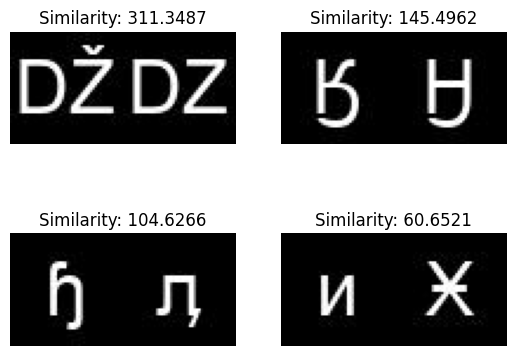

In [20]:
def plot_results(data, S, indexes):
    plot_indexes = [0, int((len(indexes) - 1) * 1e-3),
                    int((len(indexes) - 1) * 1e-2), int((len(indexes) - 1) * 1e-1)]  #后面将要显示的四张图片的索引组成的list
    fig, axs = plt.subplots(2, 2) #创建一个有4个子图的画布
    for r in range(2):
        for c in range(2):
            # >>> TODO
            img_pair_x,img_pair_y = indexes[plot_indexes[r*2+c]]  #取出要显示的图片的索引（首先得到一个二元组，然后两个元素分别赋值给img_pair_x和..._y）
            # 这里的索引是两张图片在data中的索引位置
            similarity = S[img_pair_x,img_pair_y]  #S储存了两张图片的相似度
            img = np.concatenate((data[img_pair_x][1],data[img_pair_y][1]),axis=1)  #axis=1表示将两张图片横向拼接
            # <<< TODO
            axs[r, c].imshow(img, cmap='gray')  #显示图片，cmap='gray'表示显示灰度图
            axs[r, c].set_title(f'Similarity: {similarity:.4f}') #设置标题
            axs[r, c].axis('off') #不显示坐标轴

plot_results(data, S, indexes)


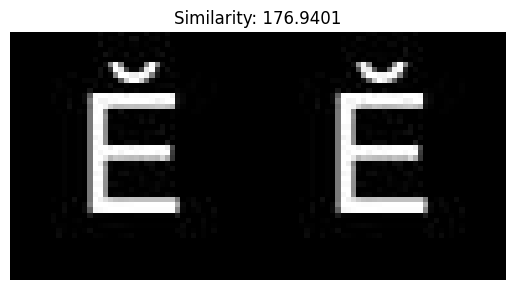

In [21]:
# 根据指定的相似度排名显示图片
def plot_simi_search(data,S,indexes,place):
    fig,axs=plt.subplots(1,1)
    img_pair_x,img_pair_y = indexes[place]
    similarity = S[img_pair_x,img_pair_y]
    img = np.concatenate((data[img_pair_x][1],data[img_pair_y][1]),axis=1)
    axs.imshow(img,cmap='gray')
    axs.set_title(f'Similarity: {similarity:.4f}')
    axs.axis('off')  
plot_simi_search(data,S,indexes,101)

## 使用 PyTorch 和矩阵运算

请仿照上一节，使用 PyTorch + 矩阵运算解决该问题。首先请你计算图像的相似度矩阵 `S`：

In [22]:
import torch
# 根据 CUDA 是否可用确定使用的设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# >>> TODO
# 请注意将 Tensor 存放在 `device` 定义的设备上。
Y_pt = torch.tensor([np.ravel(data[i][1].astype(np.float32)/255) for i in range(len(data))],device=device)
W_pt = Y_pt @ Y_pt.T
S_pt = W_pt # 感觉是否除N没有特别大的意义，因为已经把每个图片各分量归一化了，个人感觉除N之后反而可能会导致比较精度下降
# <<< TODO
print(len(W_pt))
print(W_pt.shape)

1252
torch.Size([1252, 1252])


请你仿照上一节，对相似度矩阵 S 的元素进行排序，并得到元素为 `(行号，列号)` 的索引列表：

In [33]:
S_pt = torch.triu(S_pt, diagonal=1)  # S 的减去主对角线的上三角矩阵
# >>> TODO
indexes_pt_dim0 = torch.argsort(torch.sort(S_pt,dim=1,descending=True)[0],dim = 0,descending=True)  #返回沿dim=0的排序后的索引序列
indexes_pt_dim1 = torch.argsort(torch.sort(S_pt,dim=0,descending=True)[0],dim = 1,descending=True)  #返回沿dim=1的排序后的索引序列


In [39]:
#indexes_pt =   [(i,j) for i,j in zip(torch.ravel(indexes_pt_dim0),torch.ravel(indexes_pt_dim1))]  #将元素转换为二元组（行号，列号）
#indexes_pt = torch.tensor(list(zip(indexes_pt_dim0.view(-1),indexes_pt_dim1.view(-1))))
indexes_pt = torch.tensor([(i,j) for i,j in zip(torch.ravel(indexes_pt_dim0),torch.ravel(indexes_pt_dim1))])
# <<< TODO
print(indexes_pt_dim0[0:10])
print(indexes_pt_dim1[0:10])
print(indexes_pt[0:10])
#这一段程序跑的非常慢？为什么？

tensor([[ 384,  414,  130,  ...,    0,    0,    0],
        [1044,  130,  970,  ...,    1,    1,    1],
        [ 385, 1098,   44,  ...,    2,    2,    2],
        ...,
        [1141,  936,  162,  ...,    7,    7,    7],
        [1098,   54,  414,  ...,    8,    8,    8],
        [ 918,  331,  331,  ...,    9,    9,    9]])
tensor([[ 429, 1074,  430,  ...,  788,  107,    0],
        [1160,  440, 1168,  ...,  107,    0,    1],
        [1160, 1168, 1153,  ...,    2,    1,    0],
        ...,
        [1182, 1180, 1162,  ...,    2,   11,    1],
        [1182, 1180, 1162,  ...,    0,   12,    3],
        [1182, 1162, 1180,  ...,    7,    8,   13]])
tensor([[ 384,  429],
        [ 414, 1074],
        [ 130,  430],
        [ 347,  609],
        [ 347,  440],
        [ 347, 1160],
        [ 347,  414],
        [ 347, 1168],
        [ 134,  919],
        [ 134, 1141]])


让我们看看 PyTorch 的结果吧！

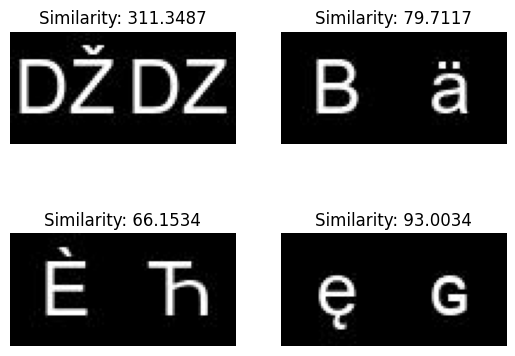

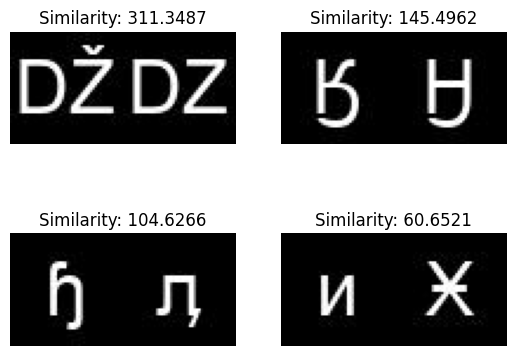

In [40]:
plot_results(data, S, indexes_pt)
plot_results(data,S,indexes)

## NumPy 和 PyTorch 速度测试

最后，让我们对比一下三种方式的执行速度。这里我们会创建一个可以统计函数运行时间的 [装饰器](https://www.liaoxuefeng.com/wiki/1016959663602400/1017451662295584)，感兴趣的同学可以点击链接了解其原理。

In [41]:
from functools import wraps
from time import perf_counter

import numpy as np #这是为了后面的测试提前导入库
import torch


def timer(func):
    # This function shows the execution time of the function object passed
    @wraps(func)
    def wrap_func(*args, **kwargs):
        args_str = ', '.join([f'{v!r}' for v in args])
        kwargs_str = ', '.join([f'{k}={v!r}' for k, v in kwargs.items()])
        comma_str = ', ' if (args_str != '' and kwargs_str != '') else ''
        t_start = perf_counter()
        result = func(*args, **kwargs)
        t_end = perf_counter()
        print(f'Function {func.__name__}({args_str}{comma_str}{kwargs_str}) executed in {(t_end - t_start):.4f}s')
        return result

    return wrap_func

接下来我们分别定义三种方式的测试函数（你需要把前面的代码复制粘贴过来）。

In [42]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

@timer
def test_numpy_for_loop():
    @timer
    def load_and_calc():
        similarity_list = []
        pair_list = []
        # >>> TODO
        for i in range(len(data)):
            for j in range(i+1,len(data)):
                pair_list.append((i,j))  #记录图片的索引（插入一个二元组）
                norm_img_1 = np.ravel(data[i][1].astype(np.float32)/255)
                norm_img_2 = np.ravel(data[j][1].astype(np.float32)/255) #归一化
                cos_theta = np.dot(norm_img_1,norm_img_2)/(np.linalg.norm(norm_img_1)*np.linalg.norm(norm_img_2))  #计算相似度（夹角余弦值）
                similarity_list.append(cos_theta) #记录相似度
        similarity_list = np.array(similarity_list) #转换为numpy数组
        pair_list = np.array(pair_list)  #转换为numpy数组
        # <<< TODO
        return similarity_list, pair_list
    similarity_list, pair_list = load_and_calc()

    @timer
    def sort():
        # >>> TODO
        indexes = np.argsort(similarity_list,axis=None)[::-1]
        # <<< TODO
        return indexes
    indexes = sort()
    return indexes


@timer
def test_numpy():
    @timer
    def load():
        # >>> TODO
        Y = np.array([np.ravel(data[i][1].astype(np.float32)/255) for i in range(len(data))])
        # <<< TODO
        return Y
    Y = load()

    @timer
    def calc():
        # >>> TODO
        W = Y @ Y.T
        # temp_N = np.array([np.linalg.norm(img) for img in Y])
        # N = temp_N @ temp_N.T
        S = W   #其实是否除N没有特别大的意义，因为已经把每个图片各分量归一化了，个人感觉除N之后反而可能会导致比较精度下降
        # <<< TODO
        S = np.triu(S, k=1)
        return S
    S = calc()

    @timer
    def sort():
        # >>> TODO
        indexes_ = np.unravel_index(np.argsort(S,axis=None)[::-1],S.shape) #返回排序后的S的下标
        indexes = [(indexes_[0][i],indexes_[1][i]) for i in range(len(indexes_[0]))]  #将元素转换为二元组（行号，列号）
        # <<< TODO
        return indexes
    indexes = sort()
    return indexes


@timer
def test_torch(device=device):
    @timer
    def load():
        # >>> TODO
        Y_pt = torch.tensor([np.ravel(data[i][1].astype(np.float32)/255) for i in range(len(data))],device=device)
        # <<< TODO
        return Y_pt
    Y_pt = load()

    @timer
    def calc():
        # >>> TODO
        W_pt = Y_pt @ Y_pt.T
        S_pt = W_pt # 感觉是否除N没有特别大的意义，因为已经把每个图片各分量归一化了，个人感觉除N之后反而可能会导致比较精度下降
        # <<< TODO
        S_pt = torch.triu(S_pt, diagonal=1)
        return S_pt
    S_pt = calc()

    @timer
    def sort():
        # # >>> TODO
        # '''
        # 感觉是这一段代码，尤其是先argsort再unravel_index的操作非常慢，但是为什么捏？
        # '''
        # indexes_pt_temp = torch.unravel_index(torch.argsort(torch.ravel(S_pt),descending=True),S_pt.shape)  #返回排序后的S的下标
        # indexes_pt = [(indexes_pt_temp[0][i],indexes_pt_temp[1][i]) for i in range(len(indexes_pt_temp[0]))]  #将元素转换为二元组（行号，列号）
        # # <<< TODO
        
        indexes_pt_dim0 = torch.argsort(torch.sort(S_pt,dim=1,descending=True)[0],dim = 0,descending=True)  #返回沿dim=0的排序后的索引序列
        indexes_pt_dim1 = torch.argsort(torch.sort(S_pt,dim=0,descending=True)[0],dim = 1,descending=True)  #返回沿dim=1的排序后的索引序列
        #indexes_pt =   [(i,j) for i,j in zip(torch.ravel(indexes_pt_dim0),torch.ravel(indexes_pt_dim1))]  #将元素转换为二元组（行号，列号）
        #indexes_pt = torch.tensor(list(zip(indexes_pt_dim0.view(-1),indexes_pt_dim1.view(-1))))
        indexes_pt = torch.tensor([(i,j) for i,j in zip(torch.ravel(indexes_pt_dim0),torch.ravel(indexes_pt_dim1))])
        return indexes_pt
    indexes_pt = sort()
    return indexes_pt

下面进行测试。

In [43]:
import cv2
from pathlib import Path
import numpy as np

def load_dataset(data_root):
    search_path = Path(data_root)  #马上要搜索的目录是data_root
    jpg_files = list(search_path.glob('**/*.jpg'))  #搜索所有后缀为jpg的文件
    data = [[file.stem, cv2.cvtColor(cv2.imread(str(file)),cv2.COLOR_BGR2GRAY)] for file in jpg_files]  #每条数据是一个列表
    #首元素是文件名，第二个元素是图片的灰度图（灰度图是一个48*48的矩阵，二维数组）
    return data
data = load_dataset(r'.\data')

In [44]:
test_numpy_for_loop()
print('-' * 50)
test_numpy()
print('-' * 50)
test_torch()
if device == 'cuda':
    print('-' * 50)
    test_torch('cpu')

Function load_and_calc() executed in 8.7325s
Function sort() executed in 0.0578s
Function test_numpy_for_loop() executed in 8.7908s
--------------------------------------------------
Function load() executed in 0.0104s
Function calc() executed in 0.0077s
Function sort() executed in 0.2974s
Function test_numpy() executed in 0.3161s
--------------------------------------------------
Function load() executed in 0.1891s
Function calc() executed in 0.0218s
Function sort() executed in 9.5737s
Function test_torch() executed in 9.7848s


你有什么发现吗？请写在下面。